# EVOLV MACHINE LEARNING CHALLENGE

### LEVEL 1
Use project-posenet repository on Github to detect pose on the images.
Through pure geometry, use the key points generated by the PoseNet to classify the yoga poses.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
os.sys.path
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

Obtaining the dowloaded prototxt and weight files from the Posenet repository.

In [3]:
protoFile = "/content/gdrive/MyDrive/pose_deploy_linevec_faster_4_stages.prototxt.txt"
weightsFile = "/content/gdrive/MyDrive/pose_iter_160000.caffemodel"

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

Loading the training images from the Google Drive and locating the body parts using the obtained prototxt and weight files. The location of body parts is appended only if the confidence of the model exceeds a certain threshold which is 0.005 in this case.

In [ ]:
main_list = []
loc = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Train/{loc[k]}/*jpg")
    images.sort()

    for i in images:
      frame = cv2.imread(i)
      frame = cv2.resize(frame, (224, 224))
      
      inHeight, inWidth, channels = frame.shape
      inp = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                    (0, 0, 0), swapRB=False, crop=False)
      net.setInput(inp)

      out = net.forward()

      BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
      "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
      "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
      "Background": 15}

      points = []
      for i in range(len(BODY_PARTS)):
          heatMap = out[0, i, :, :]

          _, conf, _, point = cv2.minMaxLoc(heatMap)
          x = (inWidth * point[0]) / out.shape[3]
          y = (inHeight * point[1]) / out.shape[2]
      
          points.append((int(x), int(y)) if conf > 0.005 else None)

      main_list.append(points)

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Train/{loc[k]}/*png")
    images.sort()

    for i in images:
      frame = cv2.imread(i)
      frame = cv2.resize(frame, (224, 224))
      
      inHeight, inWidth, channels = frame.shape
      inp = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                    (0, 0, 0), swapRB=False, crop=False)
      net.setInput(inp)

      out = net.forward()

      BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
      "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
      "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
      "Background": 15}

      points = []
      for i in range(len(BODY_PARTS)):
          heatMap = out[0, i, :, :]

          _, conf, _, point = cv2.minMaxLoc(heatMap)
          x = (inWidth * point[0]) / out.shape[3]
          y = (inHeight * point[1]) / out.shape[2]
      
          points.append((int(x), int(y)) if conf > 0.005 else None)

      main_list.append(points)

Saving the obtained list of location of the body parts as a pickle file so that they can be used again without passing the images through the model again.

In [ ]:
import pickle
f_name = "0point005.pkl"

open_file = open(f_name, "wb")
pickle.dump(main_list, open_file)
open_file.close()

Loading the saved pickle file.

In [4]:
import pickle
open_file = open('/content/0point005.pkl', "rb")
main_list = pickle.load(open_file)
open_file.close()

The locations of the body parts of the first image are shown below.

In [5]:
main_list[0]

[(80, 160),
 (88, 120),
 (88, 120),
 (56, 152),
 (32, 176),
 (88, 120),
 (64, 152),
 (32, 184),
 (128, 80),
 (32, 176),
 (200, 184),
 (128, 80),
 (32, 176),
 (24, 184),
 (112, 104),
 (56, 120)]

Filling (0,0) as the co-ordinates for the points that were not located by the PoseNet model.

In [6]:
main_list = [[v if v is not None else (0, 0) for v in nested] for nested in main_list]

Storing the target variable labels in a list.

In [7]:
true_label = []
loc = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Train/{loc[k]}/*jpg")
    images.sort()
    for i in images:
      true_label.append(loc[k])

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Train/{loc[k]}/*png")
    images.sort()
    for i in images:
      true_label.append(loc[k])

## CLASSIFICATION
I assumed that classifying the obtained locations of body parts through the PoseNet model through Pure Geometry to mean manually hard-coding a set of rules that classify the obtained data into the right category of poses. <br>

In [8]:
# BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
#       "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
#       "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
#       "Background": 15}

# loc = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

pred_label = []
points = main_list
for i in range(len(points)):
  min_x, max_x, min_y, max_y = 300, 0, 300, 0
  for j in range(len(points[0])-1):
    if points[i][j][0] > max_x:
      max_x = points[i][j][0]
    if points[i][j][0] < min_x:
      min_x = points[i][j][0]
    if points[i][j][1] > max_y:
      max_y = points[i][j][0]
    if points[i][j][1] < min_y:
      min_y = points[i][j][0]
  mid_pt_y = (points[i][8][1] + points[i][11][1]) / 2
  mid_pt_x = (points[i][8][0] + points[i][11][0]) / 2
  if ((abs(points[i][4][0] - points[i][7][0]) < 15) and (points[i][4][1] > points[i][8][1])):
    pred_label.append('tree')
  elif (min_y == points[i][8][1] or min_y == points[i][11][1]):
    pred_label.append('downdog')
  # elif ((min_y == points[i][4][1] or min_y == points[i][7][1]) and (abs(mid_pt_x - points[i][10][0]) < 15 or abs(mid_pt_x - points[i][13][0]) < 15)):
  #   pred_label.append('tree')
  elif ((points[i][7][1] == points[i][10][1] or points[i][4][1] == points[i][10][1])):
    pred_label.append('plank')
  elif (abs(points[i][4][0] - points[i][7][0]) > 40):
    pred_label.append('warrior2')
  elif (abs(points[i][4][0] - points[i][7][0]) < 40):
    pred_label.append('goddess')
  # elif ((abs(abs(mid_pt_x - points[i][12][0]) - abs(mid_pt_x - points[i][9][0])) < 20) and abs(points[i][12][0] - points[i][9][0]) < 10):
  #   pred_label.append('goddess')
  # elif (abs(abs(mid_pt_y - points[i][4][1]) - abs(mid_pt_y - points[i][7][1])) < 20 and (abs(mid_pt_y - points[i][4][1]) > 10)):
  #   pred_label.append('warrior2')
  else: pred_label.append('None')

In [9]:
y_true = pd.DataFrame(true_label, columns=['Label'])
y_true.head()
y_true.value_counts()

Label   
warrior2    238
plank       233
downdog     225
tree        150
goddess     142
dtype: int64

In [10]:
y_pred = pd.DataFrame(pred_label, columns=['Label'])
y_pred.head()
y_pred.value_counts()

Label   
tree        267
warrior2    256
goddess     253
downdog     144
plank        49
None         19
dtype: int64

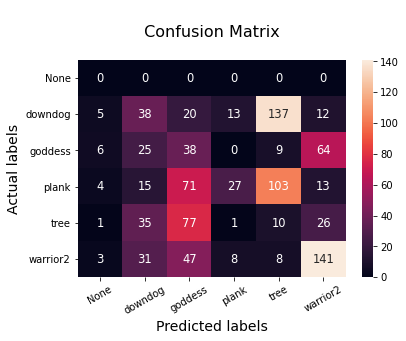

In [11]:
cm = confusion_matrix(y_true, y_pred)
l1 = ['None', 'downdog', 'goddess', 'plank', 'tree', 'warrior2']
l2 = ['None', 'downdog', 'goddess', 'plank', 'tree', 'warrior2']
ax = plt.axes()
sns.heatmap(cm, ax = ax, annot=True, annot_kws={"size": 11.5}, xticklabels=l1, yticklabels=l2, fmt='g')
ax.set_title('\n Confusion Matrix \n', fontsize = 16)
ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('Actual labels', fontsize = 14)
plt.xticks(rotation = 30)
plt.show()

In [12]:
print(accuracy_score(y_true, y_pred))

0.25708502024291496
